In [1]:
import torch
import torch.distributions as dist
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import numpy as np 
from scipy.stats import norm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
import sys
from torch.utils.data import DataLoader, TensorDataset
from torchsummary import summary
from numpy import linalg as LA

In [31]:
# print('__Python VERSION:', sys.version)
# print('__pyTorch VERSION:', torch.__version__)
# print('__CUDA VERSION', )
# from subprocess import call
# # call(["nvcc", "--version"]) does not work
# ! nvcc --version
# print('__CUDNN VERSION:', torch.backends.cudnn.version())
# print('__Number CUDA Devices:', torch.cuda.device_count())
print('__Devices')
# call(["nvidia-smi", "--format=csv", "--query-gpu=index,name,driver_version,memory.total,memory.used,memory.free"])
print('Active CUDA Device: GPU', torch.cuda.current_device())
print ('Available devices ', torch.cuda.device_count())
# print ('Current cuda device ', torch.cuda.current_device())

__Devices
Active CUDA Device: GPU 0
Available devices  1


# Data Acquisition and preprocessing

In [17]:
S1=np.loadtxt('S11_batch1K.txt')
S2=np.loadtxt('S11_batch2-10K.txt')
S11=np.concatenate((S1,S2),axis=0)
S11=np.delete(S11,[499,572,874,1165,1308,2204,2754,3635,7283,8645,9560,9598],axis=0)

x1=np.loadtxt("X_batch1K.txt")
x1=x1[:,0:8]
x2=np.loadtxt("X_batch2-10K.txt")
x2=x2[:,0:8]
y1=np.loadtxt("Y_batch1K.txt")
y1=y1[:,0:8]
y2=np.loadtxt("Y_batch2-10K.txt")
y2=y2[:,0:8]
XX=np.concatenate((x1,x2),axis=0)
YY=np.concatenate((y1,y2),axis=0)
# print(S1.shape,x1.shape,y1.shape)
xy=np.concatenate((XX,YY),axis=1)
xx=np.delete(xy,[499,572,874,1165,1308,2204,2754,3635,7283,8645,9560,9598],axis=0)

print(xx.shape,S11.shape)

(10173, 16) (10173, 128)


In [18]:
S11= S11/10
yy=10**S11
np.max(yy)

0.9921789298130084

In [19]:
lower = np.array([-0.03,-0.03,-0.03,-0.03,-0.03,-0.03,-0.03,-0.03,
                  -0.03,-0.03,-0.03,-0.03,-0.03,-0.03,-0.03,-0.03])
                  

upper = np.array([0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,
                  0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03])
                  
for i in range (np.shape(xx)[0]):
    xx[i] = (xx[i]-lower)/(upper-lower)
print(xx.shape,yy.shape)

(10173, 16) (10173, 128)


In [20]:
xx=torch.from_numpy(xx)
yy=torch.from_numpy(yy)
yy.shape

torch.Size([10173, 128])

# Data Visualization

Data input shape: torch.Size([10173, 16]) Data output shape: torch.Size([10173, 128])


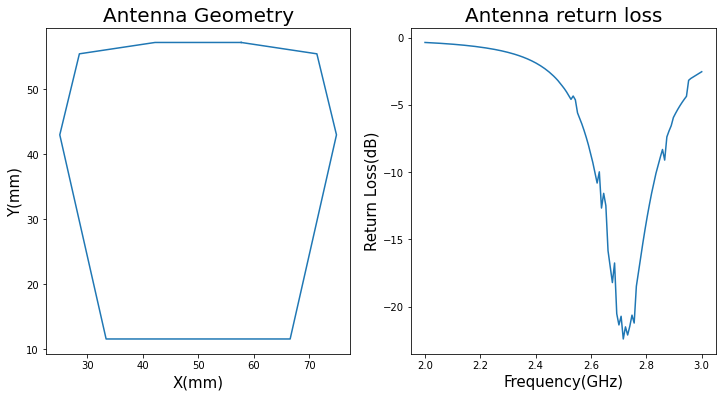

In [128]:
print ("Data input shape:",xx.shape,       "Data output shape:",yy.shape)

rr= np.random.randint(10173)
act=xx[rr]
x= np.append(act[0:8],act[0])
x=x*100
y = np.append(act[8:16],act[8])
y=y*100

freq = np.linspace(2,3,128)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.plot(x, y)
ax1.set_xlabel('X(mm)',fontsize=15)
ax1.set_ylabel('Y(mm)',fontsize=15)
ax1.set_title('Antenna Geometry',fontsize=20)
ax2.plot(freq,10*np.log(yy[rr]))
ax2.set_ylabel('Return Loss(dB)',fontsize=15)
ax2.set_xlabel('Frequency(GHz)',fontsize=15)
ax2.set_title('Antenna return loss',fontsize=20)
plt.show()

In [22]:
torch.manual_seed(23) 
X_train, X_test, y_train, y_test = train_test_split(xx, yy, test_size=0.2, random_state=34)

X_train = X_train.unsqueeze(2) 
X_test = X_test.unsqueeze(2)
print('X_train:',X_train.shape,'X_test:',X_test.shape,'y_train:',y_train.shape,'y_test:',y_test.shape)


X_train: torch.Size([8138, 16, 1]) X_test: torch.Size([2035, 16, 1]) y_train: torch.Size([8138, 128]) y_test: torch.Size([2035, 128])


In [23]:
X_train = X_train.float()
X_test = X_test.float()
y_train = y_train.float()
y_test = y_test.float()

# Surrogate model-1

In [24]:
# Define the model
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim, dropout_prob=0.5):
        super(MLP, self).__init__()
        # Adjusted kernel sizes to avoid errors with small input size
        self.conv1 = nn.Conv1d(in_channels=input_dim, out_channels=32, kernel_size=1)
        self.bn1 = nn.BatchNorm1d(32)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=128, kernel_size=1)
        self.bn2 = nn.BatchNorm1d(128)
        self.conv3 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=1)
        self.bn3 = nn.BatchNorm1d(256)
        self.conv4 = nn.Conv1d(in_channels=256, out_channels=512, kernel_size=1)
        self.bn4 = nn.BatchNorm1d(512)
        self.conv5 = nn.Conv1d(in_channels=512, out_channels=512, kernel_size=1)
        self.bn5 = nn.BatchNorm1d(512)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(512, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, output_dim)
        
        self.dropout1 = nn.Dropout(p=dropout_prob)
        self.dropout2 = nn.Dropout(p=dropout_prob)
        self.dropout3 = nn.Dropout(p=dropout_prob)
        self.dropout4 = nn.Dropout(p=dropout_prob)
        self.dropout5 = nn.Dropout(p=dropout_prob)
        self.dropout6 = nn.Dropout(p=dropout_prob)

    def forward(self, x):        
        x = self.bn1(F.relu(self.conv1(x)))
        x = self.bn2(F.relu(self.conv2(x)))
        x = self.dropout2(self.bn3(F.relu(self.conv3(x))))
        x = self.dropout3(self.bn4(F.relu(self.conv4(x))))
        x = self.dropout4(self.bn5(F.relu(self.conv5(x))))
        x = self.flatten(x)       
        x = self.dropout5(F.relu(self.fc1(x)))        
        x = self.dropout6(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x
  

In [25]:
def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    # Convert data into DataLoader for batching
    train_losses = []
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs.to(dev))
            loss = criterion(outputs, targets.to(dev))
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * inputs.size(0)  # Accumulate loss
        epoch_loss /= len(train_loader.dataset)  # Average loss over the dataset
        train_losses.append(epoch_loss)
        if (epoch+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')
    return train_losses

def plot_single_sample_prediction(model, X_test, y_test, sample_idx=0):
    model.eval()
    
    with torch.no_grad():
        single_sample_input = X_test[sample_idx].unsqueeze(0)
        predicted_output = model(single_sample_input).cpu().squeeze().detach().numpy()
    freq =torch.linspace(2,3,128)
    plt.plot(freq,predicted_output, label='Predicted')
    plt.plot(freq,y_test[sample_idx].cpu().detach().numpy(), label='Ground Truth')
    plt.legend()
    plt.title('Prediction for a Single Sample')
    plt.xlabel('Frequency(GHz)')
    plt.ylabel('Return loss')
    plt.show()

def plot_loss(train_losses,test_losses=None):
    plt.plot(train_losses,label='train')
    if test_losses:
        plt.plot(test_losses, label='Test Loss')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE_Loss')
    plt.legend()
    plt.show()
       

In [12]:
# if torch.cuda.is_available():  
#   dev = "cuda:1" 
# else:  
#   dev = "cpu" 

In [32]:
dev = "cuda:0"

Model Training

In [84]:
# Initialize the model
input_dim = 16  
output_dim = 128  
model = MLP(input_dim, output_dim)
model=model.to(dev)
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
training = train_model(model, train_loader, criterion, optimizer, num_epochs=1000)

Epoch [100/1000], Loss: 0.0244
Epoch [200/1000], Loss: 0.0158
Epoch [300/1000], Loss: 0.0125
Epoch [400/1000], Loss: 0.0097
Epoch [500/1000], Loss: 0.0085
Epoch [600/1000], Loss: 0.0080
Epoch [700/1000], Loss: 0.0075
Epoch [800/1000], Loss: 0.0068
Epoch [900/1000], Loss: 0.0081
Epoch [1000/1000], Loss: 0.0065


In [533]:
# torch.save(model.state_dict(), 'ant_model.pth')

In [35]:
model = MLP(16,128)
model.load_state_dict(torch.load('ant_model.pth', map_location=dev))
# torch.cuda.current_device()
model.to(dev)
# model.eval()

MLP(
  (conv1): Conv1d(16, 32, kernel_size=(1,), stride=(1,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(32, 128, kernel_size=(1,), stride=(1,))
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv1d(128, 256, kernel_size=(1,), stride=(1,))
  (bn3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv1d(256, 512, kernel_size=(1,), stride=(1,))
  (bn4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv1d(512, 512, kernel_size=(1,), stride=(1,))
  (bn5): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (dropout1): Dropout(

In [36]:
# Test the model
criterion = nn.MSELoss()
model.eval()
with torch.no_grad():
    test_outputs = model(X_test.to(dev))
    test_loss = criterion(test_outputs, y_test.to(dev))
    print(f'Test Loss: {test_loss.item():.4f}')

Test Loss: 0.0061


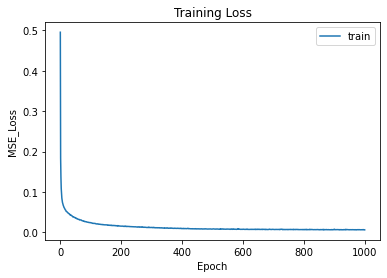

In [86]:
# Plot the training loss
# plot_loss(training,[test_loss.item()] * len(training))
plot_loss(training)

1615


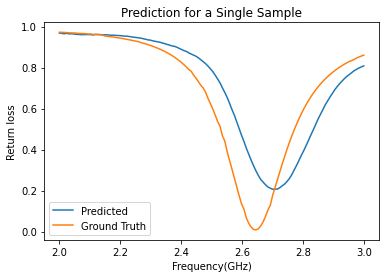

In [17]:
# Plot prediction for a single sample
rr= np.random.randint(2034)
print(rr)
plot_single_sample_prediction(model, X_test.to(dev), y_test.to(dev),sample_idx=rr)

# MC_Dropout

In [189]:
# Get the predictions for the test set with dropout set to True
def posterior_predictive(model, x, p = 0.5):
    preds = []
    model.train()
#     print(x.shape)
    for i in range(1000):
        with torch.no_grad():
            y_hat_dropout = model(x.to(dev))
        preds.append(y_hat_dropout.cpu().detach().numpy())
    preds=np.array(preds)
#     print(preds.shape)
    # Calculate mean and standard deviation across MC dropout samples
    mean_predictions = np.mean(preds, axis=0)
    std_predictions = np.std(preds, axis=0)
    return mean_predictions, std_predictions


def plot_mean_std_prediction(mean_predictions, std_predictions, ground_truth, sample_idx):
    plt.figure(figsize = (11, 8),dpi =300)    
    mean = mean_predictions[sample_idx]
    std = std_predictions[sample_idx]

    freq = torch.linspace(2, 3, 128)[:, None]
    plt.plot(freq, 10*np.log(mean), label='Mean Prediction')
    plt.plot(freq, 10*np.log(ground_truth[sample_idx]), label='Ground Truth')
    plt.fill_between(freq.squeeze(), 10*np.log(mean - 1 * std), 10*np.log(mean + 1 * std), color='gray', alpha=0.2, label='uncertainity')
    plt.title('Surrogate model(using MC Dropout) Prediction',fontsize=20)
    plt.xlabel('Frequency(GHz)',fontsize=15)
    plt.ylabel('Return loss(dB)',fontsize=15)
    
    plt.legend()
    plt.show()


In [38]:
mean_predictions, std_predictions = posterior_predictive(model,X_test)

In [39]:
std_predictions.shape

(2035, 128)

785


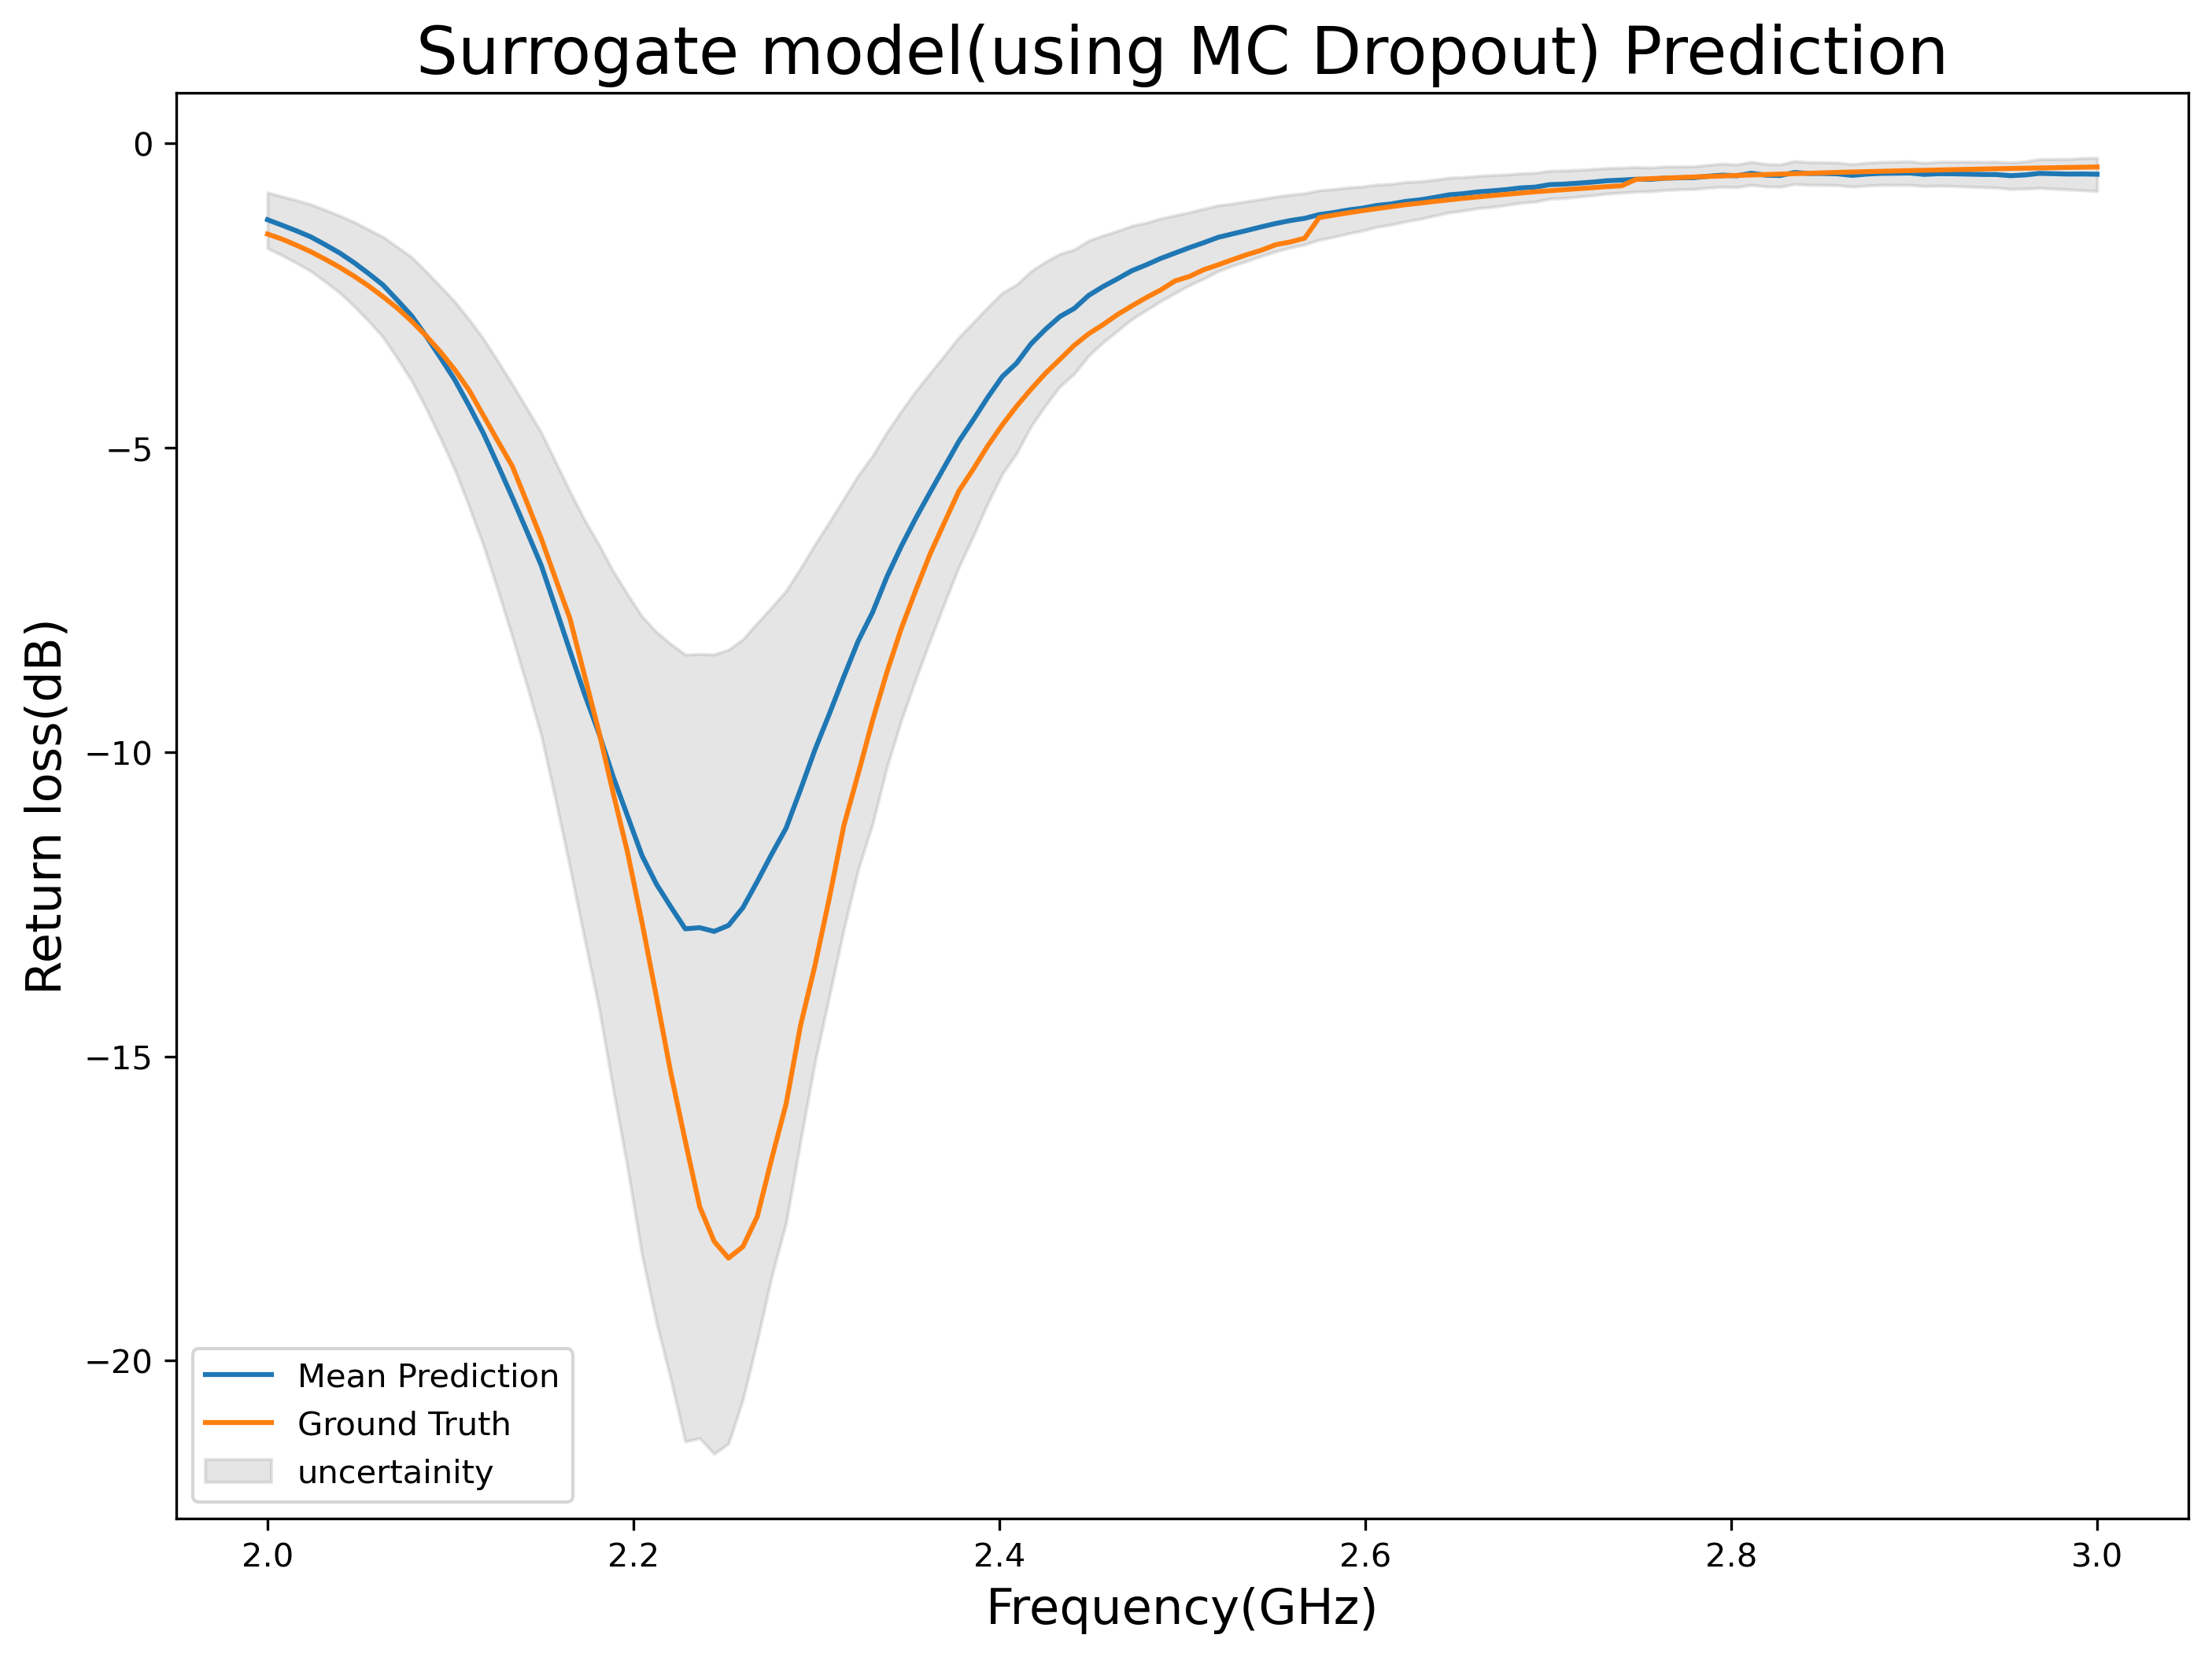

In [190]:
# Plotting mean and uncertainity
mean_predictions = np.reshape(mean_predictions,(len(X_test),128))
std_predictions = np.reshape(std_predictions,(len(X_test),128))
rr = np.random.randint(2034)
print(rr)
sample_idx = 1807
plot_mean_std_prediction(mean_predictions, std_predictions, y_test.detach().numpy(), sample_idx)

# Goal is to find (label) antenna geometry which gives the minimum of Return loss using Bayesian optimization

Unlabelled Dataset

In [41]:
print('X_test:',X_test.shape,'y_test:',y_test.shape,'global min',10*np.log(y_test.min()))

X_test: torch.Size([2035, 16, 1]) y_test: torch.Size([2035, 128]) global min tensor(-106.2355)


# Bayesian Optimization

Acquisition Function

In [42]:
# Acquisition function
def probability_of_improvement(mean_predictions, std_predictions, y_min, epsilon=1e-3):
    z = (mean_predictions - y_min - epsilon) / (std_predictions)
    pi = norm.cdf(z)
    return pi

def upper_confidence_bound(mean_predictions, std_predictions, beta=1.0):
    ucb = mean_predictions + beta * std_predictions
    return ucb
def lower_confidence_bound(mean_predictions, std_predictions, kappa=1.0):
    lcb = mean_predictions - kappa * std_predictions
    return lcb

In [43]:
X_train = X_train.float()
X_test = X_test.float()
y_train = y_train.float()
y_test = y_test.float()

In [51]:
def update(model, x_new, y_new, optimizer, criterion, num_epochs=100):
    x_new = torch.tensor(x_new, dtype=torch.float32)
    y_new = torch.tensor(y_new, dtype=torch.float32)

        # Training loop for updating the model parameters
    model.train()
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        outputs = model(x_new.to(dev)) 
        loss = criterion(outputs, y_new.to(dev))
        loss.backward()
        optimizer.step()
    return model

X_dataset = X_test.clone()
y_dataset = y_test.clone()

def plot_mean_std_pred(mean_predictions, std_predictions, ground_truth, sample_idx):    
        plt.figure(figsize=(8, 5))
        mean = mean_predictions[sample_idx]
        std = std_predictions[sample_idx]

        freq = torch.linspace(2, 3, 128)[:, None]

        plt.plot(freq, (mean), label='Mean Prediction')
        plt.plot(freq, ground_truth[sample_idx], label='Ground Truth')
        plt.fill_between(freq.squeeze(), (mean - 1 * std), (mean + 1 * std), color='gray', alpha=0.2, label='uncertainity')
        plt.title('Posterior Predictive Plot')
        plt.xlabel('Frequency')
        plt.ylabel('Return loss')

        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=15, borderaxespad=0.)
        plt.show()

# Bayesian optimization loop with X_test as the unlabeled dataset
def bayesian_optimization_loop(model, num_iterations, acquisition_function,X_new, y_new, X_dataset, y_dataset, optimizer, num_epochs=1000):
    X_data_full = X_dataset.clone()
    y_data_full = y_dataset.clone()
    X_train = X_new.clone()
    y_train = y_new.clone()
    X_obs = X_train.clone()
    y_obs = y_train.clone()
    min_values =[]
    # loading initial trained model
#     model = MLP(16,128)
#     model.load_state_dict(torch.load('ant_model.pth'))
#     model.to(dev)
    
    for i in range(num_iterations):
        if (i + 1) % 10 == 0:
            print('iteration:',i)
        # Update model with current data
#         print(X_new.shape)
        X_obs = torch.cat((X_train,X_train),0)
        y_obs = torch.cat((y_train,y_train),0)
        
        model = update(model, X_obs.to(dev), y_obs.to(dev), optimizer, criterion, num_epochs=num_epochs)
        
        # Perform MC dropout prediction
        mean_predictions, std_predictions = posterior_predictive(model, X_dataset, p=0.5)
#         print(mean_predictions.shape,X_dataset.shape)
        y_min = y_train.min()
        
        # Calculate acquisition function values
        acquisition_values = acquisition_function(mean_predictions, std_predictions, y_min.detach().numpy())
        acquisition_values = acquisition_values.mean(1)
        
         # Select new point with lowest acquisition value
#         print('acq',acquisition_values.shape)
        next_idx = np.argmin(acquisition_values)
#         print('next_idx',next_idx)
        next_idx1 = torch.tensor([[next_idx]], dtype=torch.long)
#         print('next_idx1',next_idx1)
        next_x = X_dataset[next_idx1]
        next_y = y_dataset[next_idx1]
#         print(X_obs.shape,next_x.squeeze(0).shape)
        if next_y.min() < y_min:
        # Add new point to training data
#             X_train = torch.cat(X_train, next_x.squeeze(0))
#             y_train = torch.cat(y_train, next_y.squeeze(0))
            X_train = torch.cat((X_train, next_x.squeeze(0)), dim=0)
            y_train = torch.cat((y_train, next_y.squeeze(0)), dim=0)

                                
        X_obs = torch.cat((X_obs, next_x.squeeze(0)), dim=0)
        y_obs = torch.cat((y_obs, next_y.squeeze(0)), dim=0)
        #recording Y_max values
        min_values.append(float(y_min))
#         if (i + 1) % 10 == 0:  
#             plot_mean_std_pred(mean_predictions, std_predictions, y_dataset.detach().numpy(), next_idx1)

        
        # Remove selected point from dataset
        X_dataset = torch.cat((X_dataset[:next_idx1], X_dataset[next_idx1+1:]), dim = 0)
        y_dataset = torch.cat((y_dataset[:next_idx1], y_dataset[next_idx1+1:]), dim = 0)
        
    return X_train, y_train, min_values


[1414]
iteration: 9


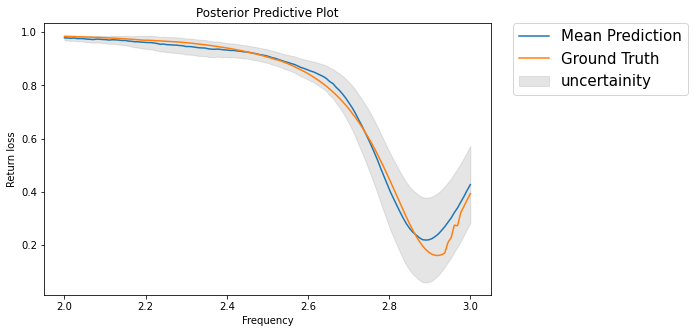

iteration: 19


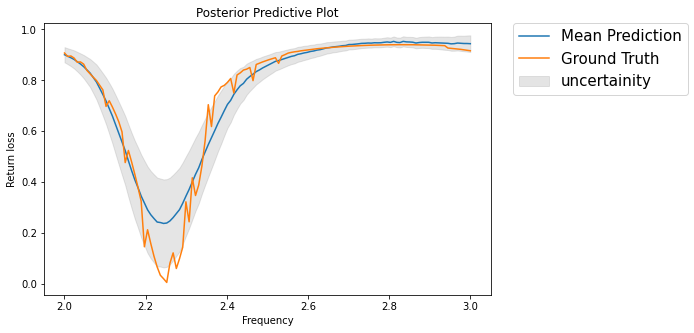

iteration: 29


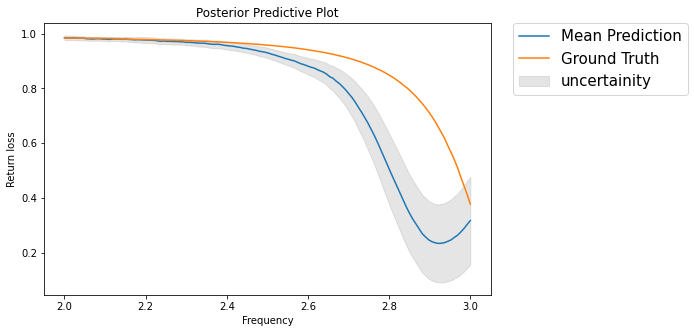

iteration: 39


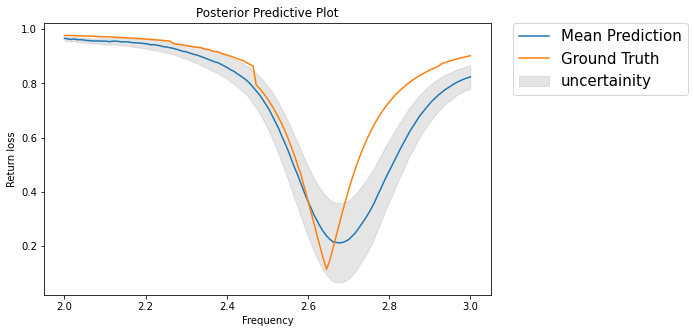

iteration: 49


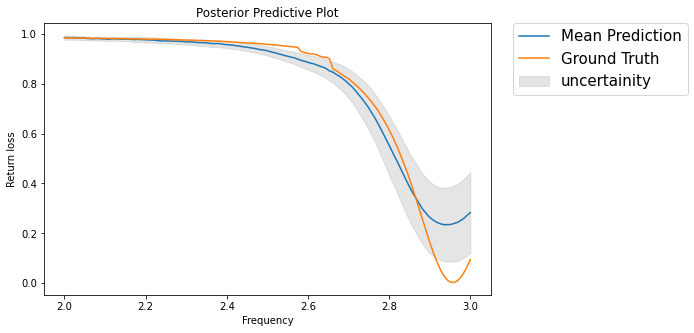

Final y:
[0.9593675136566162, 0.4205125868320465, 0.0550362691283226, 0.04253505542874336, 0.0036722056102007627, 0.0036722056102007627, 0.0036722056102007627, 0.0022948747500777245, 0.0022948747500777245, 0.0022948747500777245, 0.0022948747500777245, 0.0006629701820202172, 0.0006629701820202172, 0.0006629701820202172, 0.0006629701820202172, 0.0006629701820202172, 0.0006629701820202172, 0.0006629701820202172, 0.0006629701820202172, 0.0006629701820202172, 0.0006629701820202172, 0.0006629701820202172, 0.0006629701820202172, 0.0006629701820202172, 0.00040044233901426196, 0.00040044233901426196, 0.00040044233901426196, 0.00040044233901426196, 0.00040044233901426196, 0.0002504286530893296, 0.0002504286530893296, 0.0002504286530893296, 0.0002504286530893296, 0.0002504286530893296, 0.0002504286530893296, 0.0002504286530893296, 0.0002504286530893296, 0.0002504286530893296, 0.0002504286530893296, 0.0002504286530893296, 0.0002504286530893296, 0.0002504286530893296, 0.0002504286530893296, 0.00025

In [187]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()
num_iterations = 50
num_epochs=100

ind = np.random.randint(2034,size = 1)
print(ind)
X_new = X_dataset[ind]
y_new = y_dataset[ind]
# print(y_new.shape)
# print(X_new.shape)
X_train, y_train, min_values_PI = bayesian_optimization_loop(model, num_iterations,probability_of_improvement,  X_new, y_new, X_dataset, y_dataset, optimizer)

# print("selected X:")
# print(X_train)
print("Final y:")
# print(y_train)
print(min_values_PI)

In [109]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()
num_iterations = 50
num_epochs=100

ind = np.random.randint(2034,size = 1)
print(ind)
X_new = X_dataset[ind]
y_new = y_dataset[ind]
# print(y_new.shape)
# print(X_new.shape)
X_train, y_train, min_values_UCB = bayesian_optimization_loop(model, num_iterations,upper_confidence_bound,  X_new, y_new, X_dataset, y_dataset, optimizer)

# print("selected X:")
# print(X_train)
# print("Final y:")
# print(y_train)
print(min_values_UCB)
# torch.save(min_values_UCB, 'min_values_UCB.pt')

[1551]
iteration: 9
iteration: 19
iteration: 29
iteration: 39
iteration: 49
[0.32720956206321716, 0.27752044796943665, 0.1818791925907135, 0.1818791925907135, 0.07721701264381409, 0.07721701264381409, 0.07721701264381409, 0.062493376433849335, 0.062493376433849335, 0.062493376433849335, 0.062493376433849335, 0.062493376433849335, 0.062493376433849335, 0.0006953749107196927, 0.0006953749107196927, 0.0006953749107196927, 0.0006953749107196927, 0.0006953749107196927, 5.6902325013652444e-05, 5.6902325013652444e-05, 5.6902325013652444e-05, 5.6902325013652444e-05, 5.6902325013652444e-05, 5.6902325013652444e-05, 5.6902325013652444e-05, 5.6902325013652444e-05, 5.6902325013652444e-05, 5.6902325013652444e-05, 5.6902325013652444e-05, 5.6902325013652444e-05, 5.6902325013652444e-05, 5.6902325013652444e-05, 5.6902325013652444e-05, 5.6902325013652444e-05, 5.6902325013652444e-05, 5.6902325013652444e-05, 5.6902325013652444e-05, 5.6902325013652444e-05, 5.6902325013652444e-05, 5.6902325013652444e-05, 5.6